# CISC/CMPE 452/COGS 400 Assignment 2 - Backpropagation (15 points)  

Please put your name and student id here

    FirstName LastName, #12345678

- The notebook file has clearly marked blocks where you are expected to write code. Do not write or modify any code outside of these blocks.
- Make sure to restart and run all the cells from the beginning before submission. Do not clear out the outputs. You will only get credit for code that has been run.
- Mark will be deducted based on late policy (-1% of the course total marks per day after due date until the end date after which no assignments will be accepted)


## [Part 1 (9 points)](#Part-1)  

### Build Model1 (7 points)  
Use Pytorch to implement a three-layer Neural Network (input layer - hidden layer - output layer) and update the weights with backpropagation  
- 1. Implement forward and calculate the output (1 point)  
- 2. Calculate errors and loss (3 points)  
- 3. Update the weights with backpropagation (1 points)  
- 4. Predict function (1 point)  
- 5. Activation function (Sigmoid function) (1 point)  

### Evaluator Function (1 point)  
Implement the evaluator function with Pytorch or Numpy only   
- Evaluation metrics include confusion matrix, accuracy, recall score, precision and F1 score

### Train and Evaluate Model1 (1 point)  
Train Model1 with customized hidden size, learning rate, number of iterations and batch size  
Use the predict function to predict the labels with the test dataset  
Evaluate the prediction results  
- Evaluation metrics include confusion matrix, accuracy, recall score, precision and F1 score

## [Part 2 (6 points)](#Part-2)  

Use another machine learning framework (**scikit-learn, Tensorflow and Pytorch**) to build MLP
e.g. 
  1. https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
  2. https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
  3. https://pytorch.org/tutorials/beginner/examples_nn/polynomial_nn.html#sphx-glr-beginner-examples-nn-polynomial-nn-py
  
### Build Model2-1 (2 points)  
Implement Model2-1 with the same hidden nodes and optimization function as the model in Part 1  
Train and validate model. Use the best model on validation dataset to test on the test dataset  

### Train and Evaluate Model2-1 (1 point)
Evaluate the prediction results  
- Evaluation metrics include confusion matrix, accuracy, recall score, precision and F1 score

### Build Model2-2 (2 points)  
Add one more hidden layer (2 hidden layers in total) to the model  
Describe Model2-2 (number of hidden nodes)  
Train and validate model. Use the best model on validation dataset to test on the test dataset  

### Train and Evaluate Model2-2 (1 point)
Evaluate the prediction results  
- Evaluation metrics include confusion matrix, accuracy, recall score, precision and F1 score

In [117]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST

In [118]:
# you can go to Edit - Notebook settings to select GPU under the Hardware accelerator
# check the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [119]:
# build the dataset (train, validation and test)
def load_MNIST(n_val=10000, n_sample=1000, sample=False):
    n_val = n_val
    n_sample = n_sample
    train = MNIST(root = '.', train = True, download = True)
    test = MNIST(root = '.', train = False, download = True)
    
    # data preprocessing
    x_train, x_test = train.data/255, test.data/255
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)
    y_train = torch.nn.functional.one_hot(train.targets)
    y_test = torch.nn.functional.one_hot(test.targets)

    data_dict = {}
    if sample:
        data_dict['x_train'] = x_train[:-n_val][:n_sample]
        data_dict['y_train'] = y_train[:-n_val][:n_sample]
        data_dict['x_val'] = x_train[-n_val:][:n_sample//10]
        data_dict['y_val'] = y_train[-n_val:][:n_sample//10]
        data_dict['x_test'] = x_test[:n_sample//10]
        data_dict['y_test'] = y_test[:n_sample//10]
    else:
        data_dict['x_train'] = x_train[:-n_val]
        data_dict['y_train'] = y_train[:-n_val]
        data_dict['x_val'] = x_train[-n_val:]
        data_dict['y_val'] = y_train[-n_val:]
        data_dict['x_test'] = x_test
        data_dict['y_test'] = y_test
    return data_dict

In [120]:
# you can start with a small sample dataset by setting sample=True
data_dict = load_MNIST(sample=False)
print('Train data shape:', data_dict['x_train'].shape)
print('Train labels shape:', data_dict['y_train'].shape)
print('Validation data shape:', data_dict['x_val'].shape)
print('Validation labels shape:', data_dict['y_val'].shape)
print('Test data shape:', data_dict['x_test'].shape)
print('Test labels shape:', data_dict['y_test'].shape)

Train data shape: torch.Size([50000, 784])
Train labels shape: torch.Size([50000, 10])
Validation data shape: torch.Size([10000, 784])
Validation labels shape: torch.Size([10000, 10])
Test data shape: torch.Size([10000, 784])
Test labels shape: torch.Size([10000, 10])


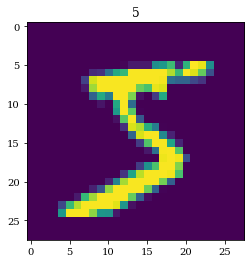

In [121]:
# plot an example
plt.rcParams['font.family']='serif'
plt.imshow(data_dict['x_train'][0].reshape(28, 28))
plt.title(data_dict['y_train'][0].argmax().item())
plt.show()

In [122]:
def evaluator(y_test, y_pred):
    ####################################################################################################
    # enter code here to implement the evaluation metrics including confusion matrix, accuracy, precision and recall
    # you can only use Numpy or Pytorch to implement the metrics
    y_test = y_test.astype("int")
    y_pred = y_pred.astype("int")

    #confussion = pd.crosstab(y_test, y_p)
    accuracy_score = np.mean((y_test.flatten() == y_pred.flatten()).astype("float"))
    
    unique_class = np.sort(np.unique(y_test))
    matrix = np.zeros((len(unique_class),
                      len(unique_class)),dtype = np.int64)
    
    for i in range(len(unique_class)):
        for j in range(len(unique_class)):
            matrix[i,j] = np.sum((y_test == i) & (y_pred == j))

    TP = matrix.diagonal()
    
    precision = np.nanmean(TP/matrix.sum(1))
    
    recall    = np.mean(TP/matrix.sum(0))

    f1 = 2 * precision * recall / (precision + recall)

    print("Confusion Matrix:\n",matrix)
    print("Accuracy:\n",accuracy_score)
    print("Precision:\n",precision)
    print("Recall:\n",recall)
    print("F1:\n",f1)

####################################################################################################

## Part 1

In [125]:
class NN(object):
    def __init__(self, learning_rate, n_iters, batch_size, hidden_size, device, dtype=torch.float32):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.device = device
        self.dtype = dtype
        self.history = {}
        self.history['train_acc'], self.history['val_acc'], self.history['loss'] = [], [], []
        self.lossfunction=nn.CrossEntropyLoss()
        self.layer1=nn.Linear(784,self.hidden_size).to(self.device)
        self.layer2=nn.Linear(self.hidden_size,10).to(self.device)
        self.optimizer=optim.Adam([{'params':self.layer1.parameters()},{'params':self.layer2.parameters()}],lr=self.learning_rate)
    
    # 5. activation function
    def sigmoid(self, x):
        ####################################################################################################
        # enter code here to implement the activation function
        
        #σ(x) = 1/(1+exp(-x))
        return 1/(1+(torch.exp(-x)))
        
        ####################################################################################################
    def sigmoid_delta(self,x):
        ## function to calculate the derivative of activation
            return x * (1 - x)

    def train(self, x, y, x_val, y_val, verbose=1):
        n_train = x.shape[0]
        n_val = x_val.shape[0]

        # TODO: train the weights with the input data and labels
        for i in range(self.n_iters):
            loss = 0
            data = getBatch(x, y, self.batch_size)
            for x_batch, y_batch in data:
                # 1. forward
                ####################################################################################################
                # enter code here to calculate the hidden layer output and output layer output
                self.optimizer.zero_grad()

                hidden_layer_output=self.layer1(x_batch.to(self.device))
                out_layer_output=self.sigmoid(self.layer2(hidden_layer_output))
                ####################################################################################################

                # 2. error and loss
                ####################################################################################################
                # enter code here to calculate the output error, MSE loss, delta output and delta hidden

                loss=self.lossfunction(out_layer_output,torch.argmax(y_batch,dim=1).to(device))

                ## compute derivative of error terms

                delta_output = self.sigmoid_delta(out_layer_output)
                delta_hidden = self.sigmoid_delta(hidden_layer_output)

                ####################################################################################################

                # 3. backward
                ####################################################################################################
                # enter code here to calculate delta weights and update the weights
                loss.backward()
                self.optimizer.step()
                ####################################################################################################

            # calculate the accuracy and save the training history
            y_pred = self.predict(x)
            train_acc = torch.sum(torch.argmax(y, dim=1) == y_pred) / n_train
            self.history['train_acc'].append(train_acc)
            self.history['loss'].append(loss)
            
            y_pred = self.predict(x_val)
            val_acc = torch.sum(torch.argmax(y_val, dim=1) == y_pred) / n_val
            self.history['val_acc'].append(val_acc)
            if verbose:
                print('epoch %d, loss %.4f, train acc %.3f, validation acc %.3f'
                  % (i + 1, loss, train_acc, val_acc))
    
    # 4. predict function 
    def predict(self, x):
        ####################################################################################################
        # enter code here to implement the predict function
        # TODO: use the trained weights to predict labels and return the predicted labels
        # remember to use torch.argmax() to return the true labels
        y_pred = self.sigmoid(self.layer2(self.layer1(x)))
        y_pred = y_pred.argmax(dim=1)
            
        
        ####################################################################################################
        return y_pred

def getBatch(x, y, batch_size):
    n_epoch = x.shape[0] // batch_size
    for i in range(n_epoch):
        x_batch = x[i * batch_size : (i+1) * batch_size]
        y_batch = y[i * batch_size : (i+1) * batch_size]
        yield x_batch, y_batch
    x_batch = x[(i+1) * batch_size:]
    y_batch = y[(i+1) * batch_size:]

    yield x_batch, y_batch



####################################################################################################
# enter code here to train Model1
# TODO: set your desired hidden size, learning rate, number of iterations and batch size
# remeber to load the dataset to the device (e.g. data_dict['x_train'].to(device))

model = NN(learning_rate=0.0001, n_iters=20, batch_size=64, hidden_size=64, device=device)
x_train = data_dict['x_train'].to(device)
y_train = data_dict['y_train'].to(device)
x_val = data_dict['x_val'].to(device)
y_val = data_dict['y_val'].to(device)
model.train(x_train, y_train ,x_val,y_val,verbose=1)

####################################################################################################


epoch 1, loss 1.8841, train acc 0.827, validation acc 0.845
epoch 2, loss 1.7906, train acc 0.858, validation acc 0.876
epoch 3, loss 1.7373, train acc 0.871, validation acc 0.885
epoch 4, loss 1.7066, train acc 0.881, validation acc 0.894
epoch 5, loss 1.6873, train acc 0.889, validation acc 0.899
epoch 6, loss 1.6735, train acc 0.894, validation acc 0.903
epoch 7, loss 1.6630, train acc 0.896, validation acc 0.906
epoch 8, loss 1.6550, train acc 0.898, validation acc 0.907
epoch 9, loss 1.6489, train acc 0.899, validation acc 0.908
epoch 10, loss 1.6442, train acc 0.900, validation acc 0.909
epoch 11, loss 1.6404, train acc 0.901, validation acc 0.910
epoch 12, loss 1.6374, train acc 0.902, validation acc 0.911
epoch 13, loss 1.6350, train acc 0.903, validation acc 0.911
epoch 14, loss 1.6329, train acc 0.904, validation acc 0.911
epoch 15, loss 1.6310, train acc 0.904, validation acc 0.912
epoch 16, loss 1.6294, train acc 0.905, validation acc 0.912
epoch 17, loss 1.6279, train acc 

In [133]:
[i.to('cpu') for i in model.history['train_acc']]

[tensor(0.8271),
 tensor(0.8583),
 tensor(0.8709),
 tensor(0.8814),
 tensor(0.8891),
 tensor(0.8936),
 tensor(0.8958),
 tensor(0.8977),
 tensor(0.8988),
 tensor(0.8999),
 tensor(0.9007),
 tensor(0.9020),
 tensor(0.9029),
 tensor(0.9036),
 tensor(0.9045),
 tensor(0.9052),
 tensor(0.9056),
 tensor(0.9062),
 tensor(0.9068),
 tensor(0.9071)]

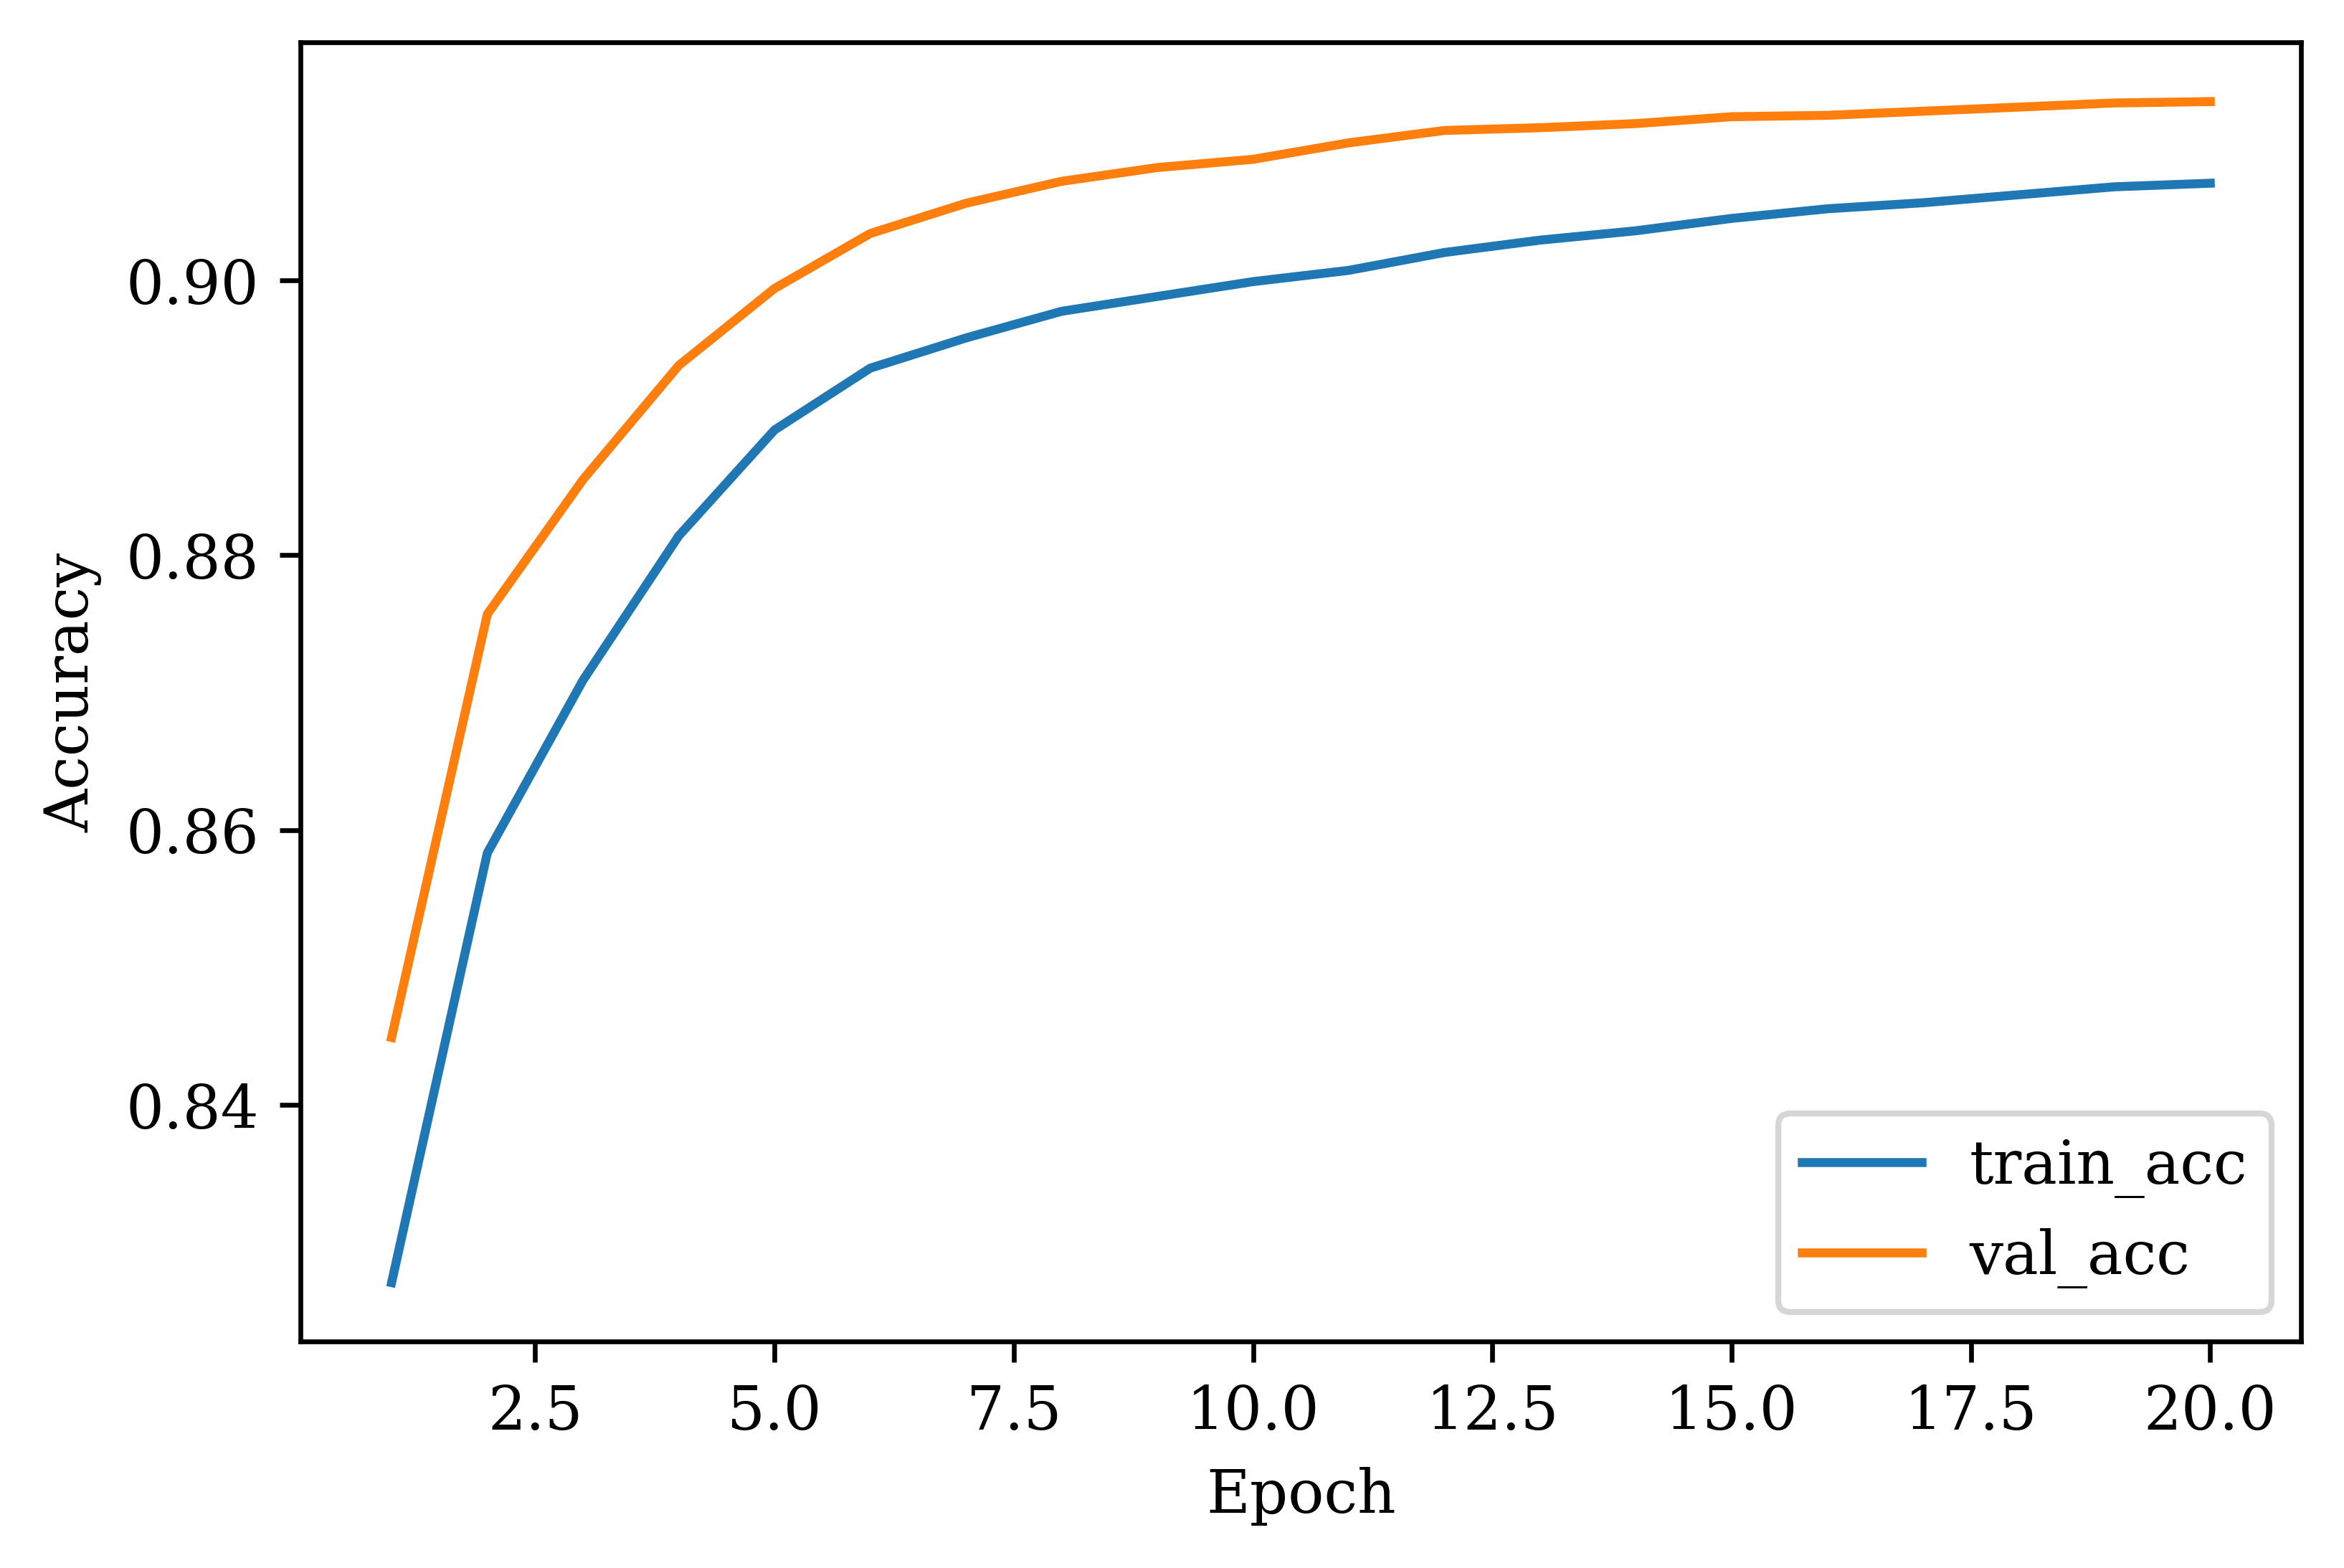

In [136]:
plt.figure(dpi=600)
plt.plot(range(1,len(model.history['train_acc'])+1),[i.to('cpu') for i in model.history['train_acc']], label='train_acc')
plt.plot(range(1,len(model.history['train_acc'])+1),[i.to('cpu') for i in model.history['val_acc']], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [144]:
####################################################################################################
# enter code here to evaluate Model1 with test set
# TODO: use the trained Model1 to predict the labels of test set and evaluate the results with the evaluator
device='cpu'
predict_train = model.predict(x_train).to(device).numpy()
predict_train

array([5, 0, 4, ..., 8, 8, 8], dtype=int64)

In [151]:
torch.argmax(y_val.to(device), dim = 1).numpy()

array([3, 8, 6, ..., 5, 6, 8], dtype=int64)

In [153]:
print("【Evaluation Metrics for Train Set】:")
evaluator(y_test = torch.argmax(y_train.to(device), dim = 1).numpy(),y_pred = predict_train)
print("")
predict_test = model.predict(x_val).to(device).numpy()
print("【Evaluation Metrics for Test Set】:")
evaluator(y_test = torch.argmax(y_val.to(device), dim = 1).numpy(),y_pred = predict_test)

####################################################################################################

【Evaluation Metrics for Train Set】:
Confusion Matrix:
 [[4728    0   29   15   13   40   43    4   54    6]
 [   1 5445   33   14    6   29    7   10  120   13]
 [  31   34 4352   83   84   16   57   72  220   19]
 [  12   24  128 4559    4  114   22   75  122   41]
 [   5   14   24    2 4420    2   32   11   43  306]
 [  42   24   26  289   85 3659   99   15  181   86]
 [  26   18   38    3   59   58 4690    3   54    2]
 [  12   33   58   15   62    8    3 4739   28  217]
 [  37   97   40  107   32  122   33   17 4287   70]
 [  28   19   16   79  143   20    2  165   42 4474]]
Accuracy:
 0.90706
Precision:
 0.9054398056343679
Recall:
 0.9068942983927025
F1:
 0.9061664683603392

【Evaluation Metrics for Test Set】:
Confusion Matrix:
 [[ 953    0    5    2    1    6   10    2    9    3]
 [   0 1031    4    2    1    5    2    1   17    1]
 [   4    5  875   19   19    6    5   16   35    6]
 [   5    2   16  929    1   24    9    5   30    9]
 [   1    9    2    1  912    0    4    2    

## Part 2

### Model2-1

In [154]:
####################################################################################################
# enter code here to implement Model2-1
from sklearn.neural_network import MLPClassifier
import numpy
clf = MLPClassifier(random_state = 1, max_iter = 200)

####################################################################################################

In [155]:
####################################################################################################
# enter code here to train Model2-1
clf.fit(data_dict['x_train'], data_dict['y_train'])

####################################################################################################

MLPClassifier(random_state=1)

In [156]:
####################################################################################################
# enter code here to evaluate Model2-1
pred = clf.predict(data_dict['x_test'])
clf.score(data_dict['x_test'], data_dict['y_test'])
pred = torch.from_numpy(numpy.argmax(pred,axis = 1))
evaluator(torch.argmax(data_dict['y_test'].to(device), dim = 1).numpy(), pred.to(device).numpy())

####################################################################################################

Confusion Matrix:
 [[ 979    0    0    1    0    0    0    0    0    0]
 [   4 1124    1    0    0    1    2    1    2    0]
 [  31    0  995    1    1    0    0    4    0    0]
 [  22    0    7  976    0    2    0    1    0    2]
 [  23    0    3    0  951    0    1    0    0    4]
 [  23    0    0   10    1  853    3    0    2    0]
 [  13    2    0    1    5    6  931    0    0    0]
 [  20    4    9    6    1    0    0  986    1    1]
 [  28    0    4    7    5    5    1    3  920    1]
 [  29    2    0    3    7    0    0    5    5  958]]
Accuracy:
 0.9673
Precision:
 0.9669455361370171
Recall:
 0.969860696431524
F1:
 0.9684009224252773


### Model2-2

In [157]:
####################################################################################################
# enter code here to implement Model2-2
clf2 = MLPClassifier(random_state = 1, max_iter = 200, hidden_layer_sizes = (100,50))

####################################################################################################

In [158]:
####################################################################################################
# enter code here to train Model2-2
clf.fit(data_dict['x_train'], data_dict['y_train'])

####################################################################################################

MLPClassifier(random_state=1)

In [159]:
####################################################################################################
# enter code here to evaluate Model2-2
pred = clf.predict(data_dict['x_test'])
clf.score(data_dict['x_test'], data_dict['y_test'])
pred = torch.from_numpy(numpy.argmax(pred, axis = 1))
evaluator(torch.argmax(data_dict['y_test'].to(device), dim = 1).numpy(), pred.to(device).numpy())

####################################################################################################

Confusion Matrix:
 [[ 979    0    0    1    0    0    0    0    0    0]
 [   4 1124    1    0    0    1    2    1    2    0]
 [  31    0  995    1    1    0    0    4    0    0]
 [  22    0    7  976    0    2    0    1    0    2]
 [  23    0    3    0  951    0    1    0    0    4]
 [  23    0    0   10    1  853    3    0    2    0]
 [  13    2    0    1    5    6  931    0    0    0]
 [  20    4    9    6    1    0    0  986    1    1]
 [  28    0    4    7    5    5    1    3  920    1]
 [  29    2    0    3    7    0    0    5    5  958]]
Accuracy:
 0.9673
Precision:
 0.9669455361370171
Recall:
 0.969860696431524
F1:
 0.9684009224252773
